# **House Prices: Advanced Regression Techniques Using PyTorch**



#### **Project Overview:**

- **Objective:** Predict house prices using advanced regression techniques.
- **Dataset:** Ames Housing dataset with 79 explanatory variables detailing various aspects of residential homes in Ames, Iowa.
- **Source:** Kaggle Competition - [House Prices-Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)
- **Acknowledgement:** Dataset was compiled by Dean De Cock as an educational resource.

#### **Dataset Overview:**

- **Variables:** Includes factors ranging from alley access types to the number of fireplaces.
- **Size:** 1460 samples with 81 columns.

## **Environment Setup**

#### **Workspace Configuration:**

1. Integrated Google Drive for seamless data access and storage in a Google Colab environment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Navigated to the specific project directory on Google Drive.



In [ ]:
%cd /content/drive/MyDrive/KDD\ Lab/PyTorch\ Project

/content/drive/MyDrive/KDD Lab/PyTorch Project


3. Listed files in the current directory to confirm the location and content.



In [ ]:
!ls

pytorch_house_prices  test.csv	train.csv


#### **Library Imports**:

1. **Data Handling and Visualization**: Essential libraries for data manipulation, analysis, and visualization were imported.



In [ ]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

2. **PyTorch**: Key components from the PyTorch library, facilitating deep learning operations, were brought in.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler

3. **Sklearn**: Utilized for data splitting and cross-validation.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

## **Data Preprocessing**

#### **Dataset Loading and Initial Observation:**

1. The training dataset was successfully loaded from its designated path.

In [ ]:
df_train_raw = pd.read_csv(r'/content/drive/MyDrive/KDD Lab/PyTorch Project/train.csv')

2. Displayed the dimensions of the loaded dataset and the first few rows for an initial overview.



In [ ]:
df_train_raw.shape

(1460, 81)

In [ ]:
df_train_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### **Exploratory Data Analysis (EDA):**

1. Visualized the distribution of the target variable 'SalePrice' using a histogram with Kernel Density Estimation (KDE) overlay.



<Axes: xlabel='SalePrice', ylabel='Count'>

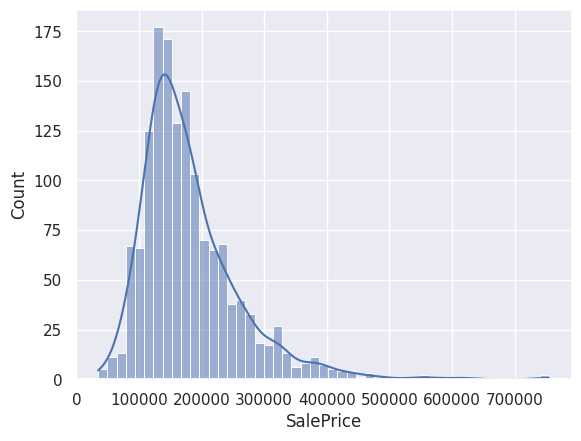

In [ ]:
sns.histplot(df_train_raw['SalePrice'], kde=True)

**Observation:** The label 'SalePrice' is positively skewed. Applying a **'log'** transformation can normalize it.

2. Visualized the missing values in the dataset to get an understanding of any gaps in the data.

<Axes: >

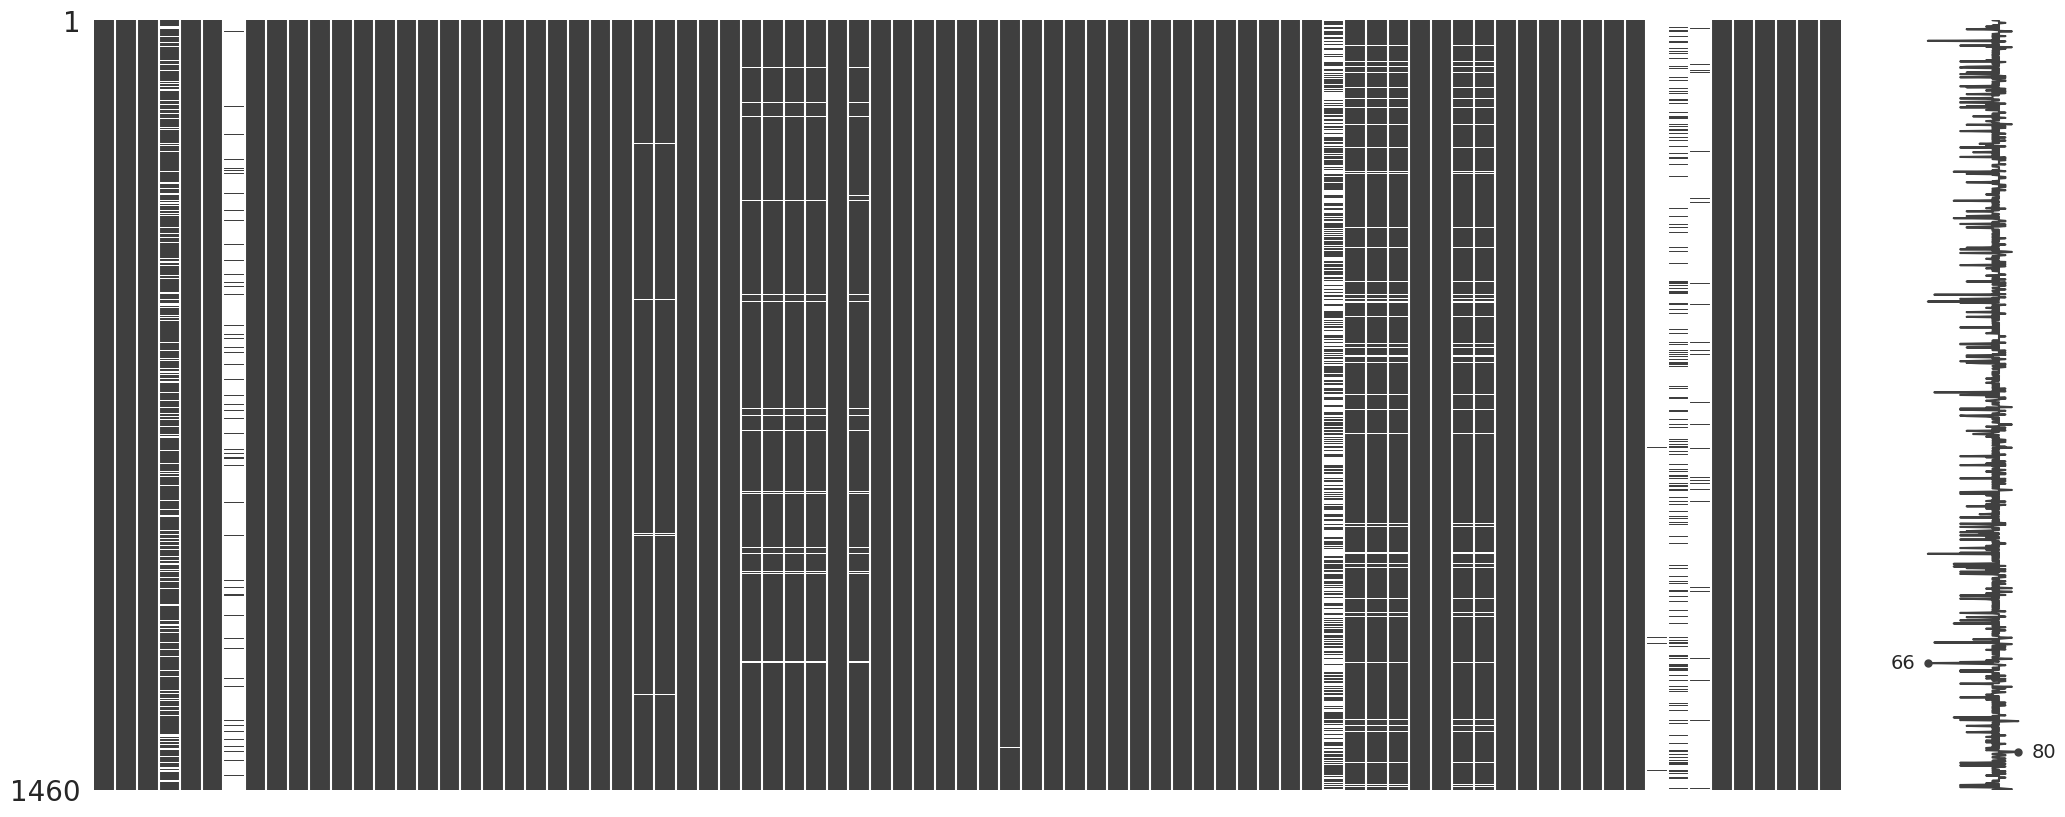

In [ ]:
msno.matrix(df_train_raw)

Blank spaces in the visualization represent missing values. Strategies for dealing with these will be applied in the preprocessing function.

### **Data Cleaning and Transformation:**

1. Function Definition: A preprocessing function was established to:
    - Drop irrelevant columns.
    - Convert categorical variables into dummy variables.
    - Normalize numerical features.
    - Handle missing values.

In [ ]:
def Preprocessing(df):
  # Make a copy to avoid changing the original
  df = df.copy()

  # Drop unnecessary columns
  df = df.drop(columns=["Id"], errors='ignore')

  # Separate columns by data type
  numeric_cols = df.select_dtypes(np.number).columns
  numeric_cols = numeric_cols.drop("SalePrice", errors='ignore')
  categorical_cols = df.select_dtypes(include=['object']).columns

  # Handle categorical columns
  df_categorical = pd.get_dummies(df[categorical_cols], dummy_na=True)

  # Normalize numeric columns and handle missing values
  df_numerical = df[numeric_cols].apply(lambda x: (x - x.mean()) / (x.std()))
  df_numerical = df_numerical.fillna(0)

  # Merge the processed numeric and categorical dataframes
  df = pd.concat([df_numerical, df_categorical], axis=1)

  return df


2. Extracted the target variable and applied a logarithmic transformation for variance stabilization.

In [ ]:
# Extract and log-transform the target
df_train_y = np.log(df_train_raw["SalePrice"], where=df_train_raw["SalePrice"] != 0)

3. Processed the feature variables using the defined preprocessing function.



In [ ]:
# Process the features
df_train_X = Preprocessing(df_train_raw)

4. Revisualized the transformed target variable to confirm distribution stabilization.



<Axes: xlabel='SalePrice', ylabel='Count'>

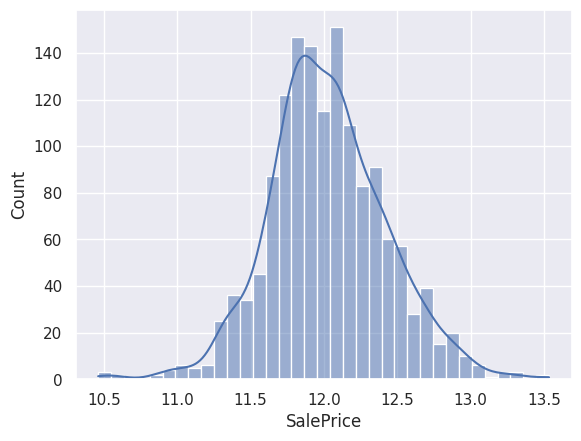

In [ ]:
sns.histplot(df_train_y, kde=True)

**Observation:** After transformation, 'SalePrice' values have become more symmetrical.

#### **Data Splitting:**

1. The dataset was split into training and validation sets, with 80% allocated for training and 20% for validation, to ensure the model's generalization capabilities.



In [ ]:
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(df_train_X, df_train_y, train_size=0.8, random_state=42)

## **Model Building**

#### **Neural Network Architecture:**

A custom neural network architecture is defined using the PyTorch framework:



In [ ]:
class Model(nn.Module):
  def __init__(self, D_in=331, H=222, D_out=1, Hn=4):
    super().__init__()

    # Activation function for our hidden layers
    self.activation = nn.Softplus()

    # Number of hidden layers
    self.Hn = Hn

    # Initial hidden layer
    self.layers = nn.ModuleList([nn.Linear(D_in, H), self.activation])

    # Add subsequent hidden layers
    for i in range(self.Hn - 1):
      self.layers.extend([nn.Linear(H, H), self.activation])

    # Output layer
    self.layers.append(nn.Linear(H, D_out))

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

#### **Components and Attributes:**

1. **Dimensions**:
    - **Input Dimension (D_in)**: The model expects 331 features as input.
    - **Hidden Layer Dimension (H)**: Each hidden layer has 222 units.
    - **Output Dimension (D_out)**: Outputs a single continuous value.
    - **Hidden Layers (Hn)**: The architecture contains 4 hidden layers by default.

2. **Activation Function**: The Softplus activation function is utilized for the hidden layers to introduce non-linearity.
```
self.activation = nn.Softplus()
```

3. **Layer Definition**:
    - An initial hidden layer is created.
    - Subsequent hidden layers are added iteratively based on the specified number Hn.
    - An output layer is appended to finalize the model structure.
```
self.layers = nn.ModuleList([nn.Linear(D_in, H), self.activation])
```
```
for i in range(self.Hn - 1):
        self.layers.extend([nn.Linear(H, H), self.activation])
```
```
self.layers.append(nn.Linear(H, D_out))
```

4. **Forward Propagation**: The **'forward'** method dictates how the input tensor traverses the network layers, resulting in an output tensor.







#### **Summary:**

A multi-layer perceptron (MLP) model is defined with customizability in terms of input features, number of units in hidden layers, and number of hidden layers. The architecture uses Softplus activation to enhance its capacity to capture complex patterns in the dataset.



## **Training Process**

#### **Environment Initialization:**

1. A function, set_seed, was defined to ensure deterministic behavior of the training, making the process reproducible.

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

set_seed(123)

2. The computing device, either GPU (cuda) or CPU, was determined for subsequent operations.



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### **Data Preparation:**

1. Training and validation data were converted to PyTorch tensors and moved to the determined device.

2. A DataLoader was set up to iterate over the training data in batches, making the process more efficient.



In [ ]:
# Convert dataframes to tensors and transfer to device
y_val = torch.tensor(df_val_y.values).float().to(device).unsqueeze(1)
X_val = torch.tensor(df_val_X.values).float().to(device)
y_train = torch.tensor(df_train_y.values).float().to(device).unsqueeze(1)
X_train = torch.tensor(df_train_X.values).float().to(device)

# Create a DataLoader for batch processing
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

#### **Model and Criterion Initialization:**

1. The neural network model was instantiated and transferred to the device.

2. An optimizer was selected, specifically the Stochastic Gradient Descent (SGD), with chosen hyperparameters such as learning rate, momentum, and weight decay.

3. Mean Squared Error Loss (MSELoss) was chosen as the criterion to measure the discrepancy between predictions and actual values.

In [ ]:
model = Model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=0.001)
criterion = nn.MSELoss()

#### **Training Loop:**

1. Lists to track training and validation losses over epochs were initialized.

2. The model underwent training for 250 epochs.

3. In each epoch:

- The model was trained using batches from the DataLoader.
- Forward and backward propagations were executed, with weight updates.
- Both training and validation losses were recorded for analysis.

In [ ]:
train_losses = []
val_losses = []
epochs = 250

for epoch in range(epochs):
    running_loss = 0.0

    for batch, (X,y) in enumerate(dataloader):
        # Forward propagation
        y_pred = model(X)
        loss = criterion(y_pred, y)
        running_loss += loss.item()

        # Backward propagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Record average training loss for the epoch
    train_losses.append(running_loss/(batch + 1))

    # Validate the model and record the validation loss
    y_pred = model(X_val)
    val_loss = criterion(y_pred, y_val).item()
    val_losses.append(val_loss)

#### **Summary:**

A comprehensive training loop was executed to optimize the neural network model using the training dataset. Periodic validation provided insights into the model's performance on unseen data, helping in avoid overfitting and ensuring generalizability.



## **Model Evaluation**

#### **Loss Visualization Over Epochs:**

The progression of loss during training is visualized over multiple epochs. These visualizations illustrate how effectively the model was trained.

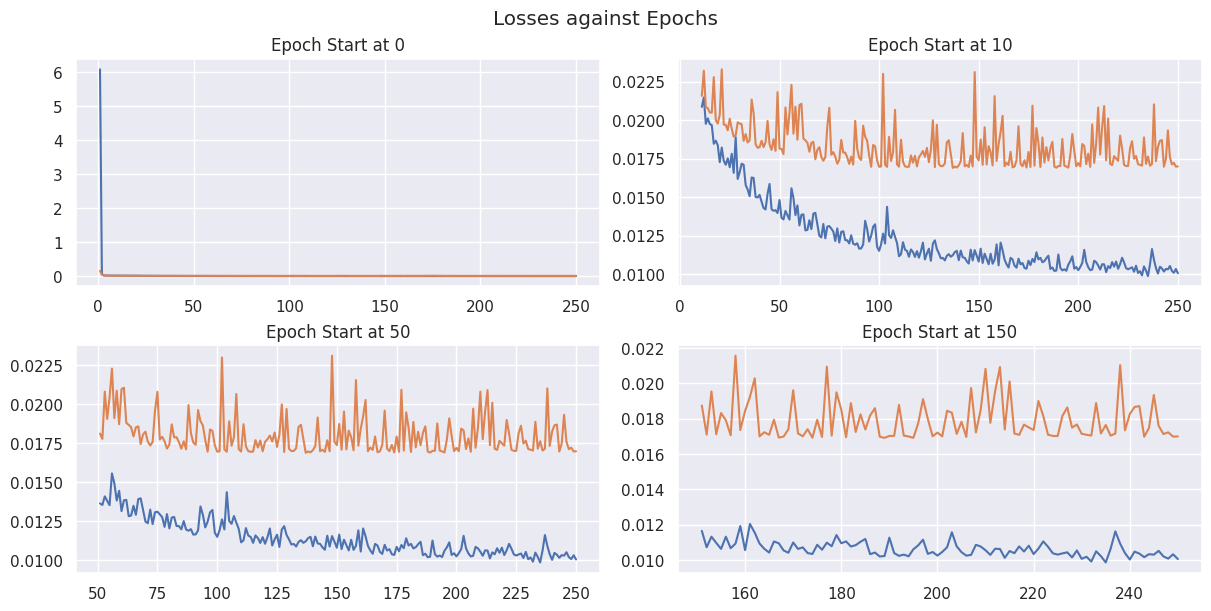

In [ ]:
def plot_loss(losses, axes=None, epoch_start=0):
    sns.set_theme(style="darkgrid")
    x = [i for i in range(1 + epoch_start, len(losses) + 1)]
    sns.lineplot(ax=axes, x=x, y=losses[epoch_start:])

def plot_epoch_loss(train_losses, test_losses, epoch1=0, epoch2=10, epoch3=50, epoch4=150):
    fig, axes = plt.subplots(2, 2, figsize=(12,6), constrained_layout=True)
    fig.suptitle("Losses against Epochs")

    # Displaying losses at various epochs
    for ax, epoch in zip(axes.ravel(), [epoch1, epoch2, epoch3, epoch4]):
        ax.set_title(f'Epoch Start at {epoch}')
        plot_loss(train_losses, ax, epoch)
        plot_loss(test_losses, ax, epoch)

plot_epoch_loss(train_losses, val_losses)

#### **Error Metrics:**

Two primary metrics, Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE), have been used to gauge model accuracy.

Functions to calculate these errors:

In [ ]:
# Extract errors from predictions
def numpy_error(model, X, y, exp=True):
    y_pred = model(X)
    if exp:
        y = torch.exp(y)
        y_pred = torch.exp(y_pred)
    errors = (y_pred - y).flatten().detach().cpu().numpy()
    return errors

# Calculate MAE
def mae(errors):
    return np.abs(errors).mean()

# Calculate RMSE
def rmse(errors):
    mse = ((errors)**2).mean()
    return np.sqrt(mse)

#### **Model's Accuracy Metrics:**

These metrics quantify the model's performance on the training and validation sets.



In [ ]:
# Error on the training set
errors_train = numpy_error(model, X_train, y_train, False)
print("Error on training set")
print(f"MAE: {mae(errors_train)}")
print(f"RMSE: {rmse(errors_train)}\n")

# Error on the testing/validation set
errors_val = numpy_error(model, X_val, y_val, False)
print("Error on testing set")
print(f"MAE: {mae(errors_val)}")
print(f"RMSE: {rmse(errors_val)}")

Error on training set
MAE: 0.06746217608451843
RMSE: 0.09724725782871246

Error on testing set
MAE: 0.08699524402618408
RMSE: 0.13036637008190155


#### **Summary:**

The model's performance is satisfactory with low MAE and RMSE values for both training and validation sets, indicating a well-balanced model.

## **Test Data Predictions**

#### **Loading & Preprocessing:**

1. The test dataset was loaded from the specified path.
2. A preprocessing function was applied to the dataset, designed to handle transformations such as normalizing numeric columns and encoding categorical ones.

In [ ]:
# Load the test dataset
df_test = pd.read_csv(r'/content/drive/MyDrive/KDD Lab/PyTorch Project/test.csv')

# Preprocess the dataset
X_test = Preprocessing(df_test)

#### **Handling Column Differences Between Train and Test:**

To ensure consistent input dimensions for the model, any columns missing in the test set (compared to the training set) were identified. For each missing column, a dummy row was appended to the test dataset with the respective category marked. This aided in generating the required columns during preprocessing.

After adding the necessary columns, the appended rows were removed to revert the test dataset to its original size.


In [ ]:
train_cols = df_train_X.columns
test_cols = X_test.columns
diff = train_cols.difference(test_cols)

added_rows = 0
idx = len(df_test)

df_test_copy = df_test.copy()
eg_row = df_test.iloc[0]

for string in diff:
    df_test_copy = df_test_copy.append(eg_row, ignore_index=True)
    col, value = string.split('_')
    df_test_copy.loc[idx, col] = value
    idx += 1
    added_rows += 1

# Re-preprocess the test dataset after adding missing columns
df_test_copy = Preprocessing(df_test_copy)
X_test = df_test_copy.iloc[:-added_rows]  # Remove the added rows

<ipython-input-56-0094091f68fc>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_test_copy = df_test_copy.append(eg_row, ignore_index=True)


#### **Prediction:**

1. The preprocessed test data was converted to a PyTorch tensor and transferred to the GPU.
2. Using the trained model, house prices for the test dataset were predicted.
3. The predicted prices, initially in log scale due to earlier transformations, were converted back to their original scale for interpretation.

In [ ]:
# Convert the test data to a tensor and move to the appropriate device (GPU)
X_test = torch.tensor(X_test.values).float().to(device)

# Predict the prices with the model
y_test = model(X_test).squeeze()

# Convert predictions back from log scale to original scale
y_test = torch.exp(y_test)

#### **Results Compilation:**

The model's predictions were compiled into a DataFrame for easier interpretation and comparison.



In [ ]:
y_test_np = y_test.cpu().detach().numpy()

results_df = pd.DataFrame({
    "Id": df_test["Id"],
    "PredPrice": y_test_np
})

# Formatting the 'Predicted SalePrice' column
results_df["PredPrice"] = results_df["PredPrice"].apply(lambda x: "${:,.2f}".format(x))

print(results_df)

        Id    PredPrice
0     1461  $118,749.16
1     1462  $158,932.28
2     1463  $188,403.00
3     1464  $198,115.36
4     1465  $187,388.05
...    ...          ...
1454  2915   $85,430.24
1455  2916   $85,359.79
1456  2917  $179,393.80
1457  2918  $119,747.77
1458  2919  $231,607.94

[1459 rows x 2 columns]


## **Conclusion**

#### **Summary:**

This project utilized the Ames Housing dataset to build an advanced regression model with PyTorch, aiming to predict house prices. Leveraging a comprehensive set of 79 explanatory variables, the developed model demonstrated promising accuracy levels in both training and validation phases.

#### **Achievements**:

- **Data Preprocessing**: Systematic handling of missing values, categorical variables, and normalization ensured data quality.

- **Model Architecture**: The model design, with multiple hidden layers and optimized parameters, effectively captured the intricacies of the dataset.

- **Performance**: With reasonably low MAE and RMSE values, the model showcased its adequate potential as a useful tool for house price prediction.

#### **Moving Forward:**

1. **Feature Importance Analysis**: Investigating the importance of each variable can provide deeper insights and possibly further improve model efficiency.

2. **Model Variations**: Exploring other architectures or ensemble methods could further enhance prediction accuracy.

I appreciate the time taken to review this project. I've gained a lot of valuable insights into PyTorch and enhanced my skill set, especially in using advanced regression techniques. Any insights, recommendations, or questions regarding this work is also welcomed. Thanks!

